Korzystaj z tego co już się nauczyłeś:

-twórz wrapery funkcji --> tych funkcji, które później rozwijasz (jest w etap 1 i 2) dekorowanie z functools.wraps
-przerzucaj to do bibliotek
-zastanów się czy można i czy jest sens robić refraktoryzacje do klas
-rób commity --> gdy zmieniasz mały fragment kodu
-stórz najprostrze flow dockera na nodach
-stwórz tabele w której odnosisz się do danego datasetu -->  skorzystaj z nakładki Sebastiana apropos hive
-stwórz bardzioj ogólne funkcje które bazuja na ścierzkach
-unitesty
-profilowanie
-dodawaj sugestie do typów zmiennych i wyjścia z funkcji metod
-korzystaj z pylint do poprawy modułów i skryptów

stwórz projekt z szablony projektów
zrób pierwszego pusha
połącz google colab z tym repo i dodawaj go do notebooks
zrób też projek template na git


Dodawaj tylko sugestie do typów
colab_quick_conception

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
class Player:
    """Just keep the money in a socket"""
    def __init__(self, months_to_simulate=0, money_to_invest=0, money=0):
        self.months_to_simulate = months_to_simulate
        self.money_to_invest = money_to_invest
        self.money = money
        self.money_timestemp = []
        self.day = 0    

    def new_day(self):
        self.day += 1

        if self.day%23 == 0:
            self.money_timestemp.append(self.whole_money())
            self.money_to_invest += 1000
        
        self.should_I_buy()
    
    def plot(self):
        plt.plot(self.money_timestemp)

    def simulate_period_of_time(self):
        for _ in range(23*self.months_to_simulate):
            self.new_day()
    
    def should_I_buy(self):
        if self.money_to_invest > 0:
            self.money += self.money_to_invest
            self.money_to_invest = 0
    
    def whole_money(self):
        return self.money
        

In [ ]:
iwda = pd.read_csv('https://stooq.pl/q/d/l/?s=iwda.uk&i=d')

In [ ]:
iwda = iwda[['Data', 'Zamkniecie']]

In [ ]:
iwda=iwda.rename(columns={'Data':'ds', 'Zamkniecie':'y'})

In [ ]:
lazy_player = Player(months_to_simulate=48)

In [ ]:
lazy_player.simulate_period_of_time()

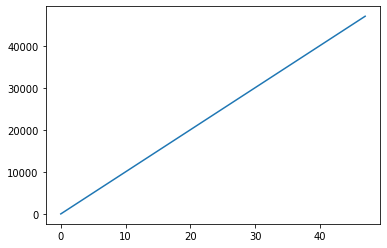

In [ ]:
lazy_player.plot()

In [ ]:
class SimplePlayer(Player):
    """Buys when he has the money"""
    def __init__(self, months_to_simulate, iwda, money_to_invest=0):
        super().__init__(months_to_simulate, money_to_invest=0)
        self.iwda = iwda['y'].values.tolist()[-23*self.months_to_simulate:]
        self.iwda_numb = 0
    
    def should_I_buy(self):
        self.avaiable_iwda = self.money_to_invest//self.iwda[self.day-1]
        if self.avaiable_iwda > 0:
            self.iwda_numb += self.avaiable_iwda
            self.money_to_invest -= self.avaiable_iwda*self.iwda[self.day-1]
            self.avaiable_iwda = 0

    def whole_money(self):
        return self.money_to_invest + self.iwda_numb*self.iwda[self.day-1]

In [ ]:
simple_player = SimplePlayer(iwda=iwda, months_to_simulate=48)

In [ ]:
simple_player.simulate_period_of_time()

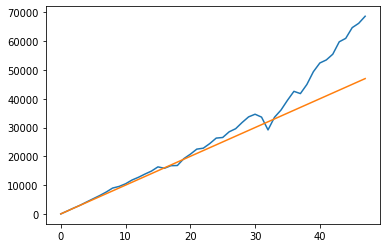

In [ ]:
simple_player.plot()
lazy_player.plot()

In [ ]:
simple_player.whole_money()/48000

1.4512287499999998

In [ ]:
simple_player.iwda_numb

817.0

naive way to simulate the strateg but I wontet to be sure that my outcome is correct, it could be slow

In [ ]:
class SimpleDipSearcher(SimplePlayer):
    '''Buys when anomaly is detected'''
    def __init__(self, months_to_simulate, iwda, money_to_invest=0):
        super().__init__(months_to_simulate, iwda, money_to_invest=0)
    
    def should_I_buy(self):
        self.avaiable_iwda = self.money_to_invest//self.iwda[self.day-1]
        if self.avaiable_iwda > 0 and self.good_deal_search():
            self.iwda_numb += self.avaiable_iwda
            self.money_to_invest -= self.avaiable_iwda*self.iwda[self.day-1]
            self.avaiable_iwda = 0
        
    def good_deal_search(self, window=10):
        try:
            x = np.arange(0,window-1)
            y = np.array(self.iwda[self.day-window:self.day-1])
            a, b = np.polyfit(x, y, 1)
            local_pred = a*window + b
            dip = 2*(self.iwda[self.day] - local_pred)/(self.iwda[self.day]+local_pred)
            return dip < -0.007
        except:
            return False

In [ ]:
simple_dip_searcher = SimpleDipSearcher(iwda=iwda, months_to_simulate=48)

In [ ]:
simple_dip_searcher.simulate_period_of_time()

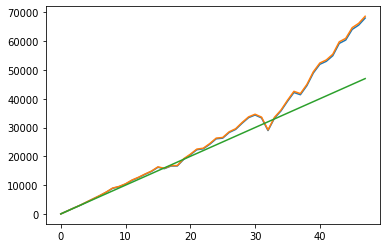

In [ ]:
simple_dip_searcher.plot()
simple_player.plot()
lazy_player.plot()


In [ ]:
simple_player.whole_money()/48000

1.4512287499999998

In [ ]:

from fbprophet import Prophet


In [ ]:
model = Prophet()
model.fit(iwda)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=3, freq = 'm')

In [ ]:
forecast = model.predict(future)

In [ ]:
forecast.loc[forecast['ds'] == iwda.iloc[-1]['ds']][['yhat_lower', 'yhat_upper']]

,yhat_lower,yhat_upper
1635,84.901318,89.17477


In [ ]:
yhat_lower

'yhat_lower'

In [ ]:
class ProphetStableSearcher(SimpleDipSearcher):
    '''Buys when anomaly is detected'''
    def __init__(self, months_to_simulate, iwda, money_to_invest=0):
        super().__init__(months_to_simulate, iwda, money_to_invest=0)
        self.df_iwda = iwda
        
    def good_deal_search(self, window=10):
        model = Prophet()
        model.fit(self.df_iwda)
        future = model.make_future_dataframe(periods=3, freq = 'm')
        forecast = model.predict(future)
        today = forecast.loc[forecast['ds'] == self.df_iwda.iloc[-1]['ds']][['yhat_lower', 'yhat_upper']]
        yhat_lower, yhat_upper = today.yhat_lower.values[0], today.yhat_upper.values[0]
        if self.iwda[-1]>yhat_lower and self.iwda[-1]<yhat_upper:
            print(forecast.iloc[-1]['yhat']/self.iwda[-1])
            print(self.iwda[-1])
            return forecast.iloc[-1]['yhat']/self.iwda[-1] > 1.03

In [ ]:
prophet_stable_searcher = ProphetStableSearcher(iwda=iwda, months_to_simulate=4)

In [ ]:
prophet_stable_searcher.simulate_period_of_time()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.061393719700659
85.26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.061393719700659
85.26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.061393719700659
85.26
1.061393719700659
85.26


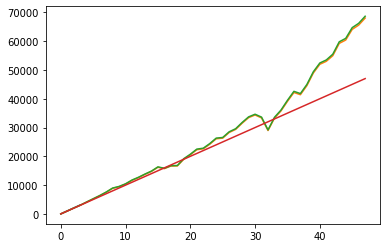

In [ ]:
prophet_stable_searcher.plot()
simple_dip_searcher.plot()
simple_player.plot()
lazy_player.plot()


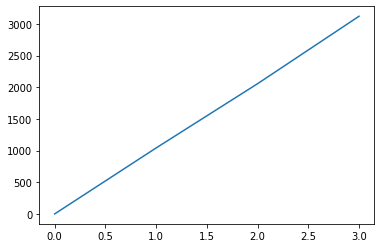

In [ ]:
prophet_stable_searcher.plot()

In [ ]:
class ProphetSearcher(SimpleDipSearcher):
    '''Buys when anomaly is detected'''
    def __init__(self, months_to_simulate, iwda, money_to_invest=0):
        super().__init__(months_to_simulate, iwda, money_to_invest=0)
        self.df_iwda = iwda
        
    def good_deal_search(self, window=10):
        try:
            model = Prophet()
            model.fit(self.df_iwda)
            future = model.make_future_dataframe(periods=3, freq = 'm')
            forecast = model.predict(future)
            today = forecast.loc[forecast['ds'] == self.df_iwda.iloc[-1]['ds']][['yhat_lower', 'yhat_upper']]
            yhat_lower, yhat_upper = today.yhat_lower, today.yhat_upper
            if self.iwda[-1]>yhat_lower and self.iwda[-1]<yhat_upper:
                
                return forecast.iloc[-1]['yhat']/self.iwda[-1] > 1.03 or yhat_lower/self.iwda[-1]<0.95
        except:
            return False

In [ ]:
prophet_searcher = ProphetSearcher(iwda=iwda, months_to_simulate=48)

In [ ]:
prophet_searcher.simulate_period_of_time()

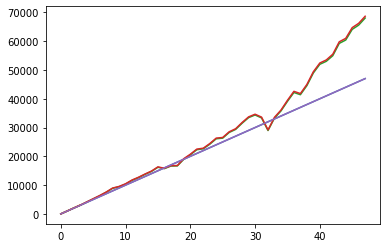

In [ ]:
prophet_searcher.plot()
prophet_stable_searcher.plot()
simple_dip_searcher.plot()
simple_player.plot()
lazy_player.plot()

może dorzucić logarytm?


dodać wektor priorytetu

Mam docelowe prororcje i tam gdzie są najbardziej oddalone od docelowych to to ma najwyższy prioryter. Mogę sprawdzic poprawę wachań portwela ofejmując liniowy trend i sprawdzając jak duże dolinki i górki zostaną

Czyli jeszcze sprawdź co daje rozwiązanie mieszane i rozwiązanie z priorytetami oraz z anomaliami i bez. I czy warto czekać na anomalie i czy nie lepiej korzytać z prostych modeli kupowania co miesiąc i tyle

Sprawdź jak działa proste rozwiązanie gdzie kupujesz raz na miesiąc

sensowne opje do przetestowania:

...


Które są najistotniejsze?



Przetestuj najistotniejsze